In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.stats import gaussian_kde

import torch
from torchmetrics.functional import spearman_corrcoef as spearman
from data import SingleCellDataset

from intensity import get_intensities
from get_ssims import get_ssims
device = torch.device('cuda:7')

# Set Panel

In [2]:
ch2stain = {0:"DAPI", 1:"CD3", 2:"NaKATPase", 3:"CD45RO", 4:"Ki67", 5:"panCK", 6:"aSMA", 7:"CD4", 8:"CD45",
            9:"PD-1", 10:"CD20", 11:"CD68", 12:"CD8a", 13:"CD163", 14:"FOXP3", 15:"PD-L1", 16:"ECad", 17:"Vim",
            18:"CDX2", 19:"LaminABC", 20:"Desmin", 21:"CD31", 22:"PCNA", 23:"Ki67", 24:"Collagen IV"}

# Get Model Checkpoints and Panel Selection Orders

In [76]:
ls ../training/pt_mae/tma_cv_5/pt_mae/2478iyl6/checkpoints/

'epoch=299-step=171600.ckpt'


In [77]:
cv_1_ckpt = '../training/pt_mae/tma_cv_1/pt_mae/3j9wr9hv/checkpoints/epoch=299-step=172800.ckpt'
cv_2_ckpt = '../training/pt_mae/tma_cv_2/pt_mae/2lup4o2d/checkpoints/epoch=299-step=172800.ckpt'
cv_3_ckpt = '../training/pt_mae/tma_cv_3/pt_mae/3f13xh37/checkpoints/epoch=299-step=172500.ckpt'
cv_4_ckpt = '../training/pt_mae/tma_cv_4/pt_mae/lcnt9i57/checkpoints/epoch=299-step=174600.ckpt'
cv_5_ckpt = '../training/pt_mae/tma_cv_5/pt_mae/2478iyl6/checkpoints/epoch=299-step=171600.ckpt'

In [78]:
panel_order = [0,7,16,12,6,11,24,1,20,14,3,15,17,19,21,10,4,9,5,8,13,18,23,22]

# Load Models

In [79]:
from mae import IF_MAE
model_cv1 = IF_MAE().load_from_checkpoint(cv_1_ckpt)
model_cv1 = model_cv1.to(device)
model_cv1 = model_cv1.eval()

model_cv2 = IF_MAE().load_from_checkpoint(cv_2_ckpt)
model_cv2 = model_cv2.to(device)
model_cv2 = model_cv2.eval()

model_cv3 = IF_MAE().load_from_checkpoint(cv_3_ckpt)
model_cv3 = model_cv3.to(device)
model_cv3 = model_cv3.eval()

model_cv4 = IF_MAE().load_from_checkpoint(cv_4_ckpt)
model_cv4 = model_cv4.to(device)
model_cv4 = model_cv4.eval()

model_cv5 = IF_MAE().load_from_checkpoint(cv_5_ckpt)
model_cv5 = model_cv5.to(device)
model_cv5 = model_cv5.eval()

# Load Data

In [80]:
import pickle
from torch.utils.data import Dataset, DataLoader

In [81]:
def get_data(split_num, BATCH_SIZE):
    data_dir = '/var/local/ChangLab/panel_reduction/CRC-TMA-2'
    with open(f'../data/cv_{split_num}_cores.pkl','rb') as f:
        train_cores = pickle.load(f)
    files = [f'{data_dir}/{f}' for f in os.listdir(data_dir)]
    test_files = [f for f in files if '-'.join(f.split('/')[-1].split('-')[:2]) not in train_cores]
    val_data = SingleCellDataset(test_files)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=0)
    return val_loader

In [82]:
val_loader_cv1 = get_data(1, 10000)
val_loader_cv2 = get_data(2, 10000)
val_loader_cv3 = get_data(3, 10000)
val_loader_cv4 = get_data(4, 10000)
val_loader_cv5 = get_data(5, 10000)

# Run Models to get Mean Intensities

In [83]:
intensities = []
models = [model_cv1, model_cv2, model_cv3, model_cv4, model_cv5]
loaders = [val_loader_cv1, val_loader_cv2, val_loader_cv3, val_loader_cv4, val_loader_cv5]
for model,val_loader in zip(models, loaders):
    intensities_ = []
    
    for panel_size in [3,6,9,12,15,18]:
        unmasked_ch_idx = panel_order[:panel_size]
        mints, pmints = get_intensities(model, unmasked_ch_idx, val_loader, device=device)
        intensities_.append((mints, pmints))
        
    intensities.append(intensities_)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:18<00:00, 12.42s/it]


# Plot Mean Intensities for Each Panel 

In [84]:
def get_corrs(mints, pmints):
    if mints.shape[1] == 1:
        stain_corrs = spearman(pmints.squeeze(), mints.squeeze())
        stain_corrs = stain_corrs.unsqueeze(0)
    else:
        stain_corrs = spearman(pmints, mints)
    return stain_corrs

In [85]:
stain_corrs_per_ratio = []
for intensities_ in intensities:
    stain_corrs = []
    for mints_, pmints_ in intensities_:
        stain_corrs.append(get_corrs(mints_, pmints_))
    stain_corrs_per_ratio.append(stain_corrs)

In [86]:
stain_corrs_per_ratio = [[s.detach().cpu().numpy() for s in stain_corrs] 
                         for stain_corrs in stain_corrs_per_ratio]

In [87]:
all_corrs = []
for corr_1, corr_2, corr_3, corr_4, corr_5 in zip(stain_corrs_per_ratio[0], stain_corrs_per_ratio[1], stain_corrs_per_ratio[2], stain_corrs_per_ratio[3], stain_corrs_per_ratio[4]):
    all_corrs.append(corr_1)
    all_corrs.append(corr_2)
    all_corrs.append(corr_3)
    all_corrs.append(corr_4)
    all_corrs.append(corr_5)

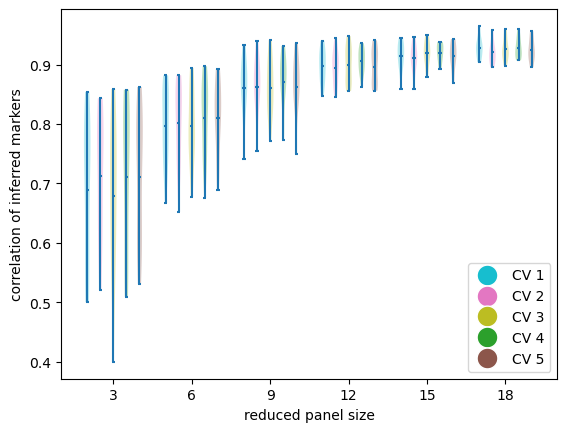

In [88]:
positions = [0.5,1.5,2.5,3.5,4.5,
             6.5,7.5,8.5,9.5,10.5,
             12.5,13.5,14.5,15.5,16.5,
             18.5,19.5,20.5,21.5,22.5,
             24.5,25.5,26.5,27.5,28.5,
             30.5,31.5,32.5,33.5,34.5]

bplot = plt.violinplot(all_corrs,positions=positions,showmeans=True)
plt.xticks([2.5, 8.5, 14.5, 20.5, 26.5, 32.5],['3','6','9','12','15','18'])
plt.xlabel('reduced panel size')
plt.ylabel('correlation of inferred markers')
#plt.title('Comparative Performance of Panel Selection Strategies')
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='tab:cyan', markersize=15),
                 Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='tab:pink', markersize=15),
                 Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='tab:olive', markersize=15),
                 Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='tab:green', markersize=15),
                 Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='tab:brown', markersize=15)
                ]

plt.legend(custom_points, ['CV 1','CV 2','CV 3', 'CV 4', 'CV 5'],loc='lower right')
for i,patch in enumerate(bplot['bodies']):
    if i % 5 == 0:
        patch.set_facecolor('tab:cyan')
    elif i % 5 == 1:
        patch.set_facecolor('tab:pink')
    elif i % 5 == 2:
        patch.set_facecolor('tab:olive')
    elif i % 5 == 3:
        patch.set_facecolor('tab:green')
    elif i % 5 == 4:
        patch.set_facecolor('tab:brown')
        
plt.show()